<h1><center>Programming Exercise 8:<br>Anomaly Detection and Recommender Systems</center></h1>

In [1]:
from scipy.io import loadmat
import numpy as np
from numpy.linalg import det, inv
import matplotlib.pyplot as plt
import matplotlib as mpl

# Global constants
pi = np.pi

mpl.rcParams['figure.figsize'] = (10,6)

# 1. Anomaly Detection
- Implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. We have collected $m=307$ samples of how they were behaving, thus giving us an unlabeled dataset $\{x^{(i)},\ldots,x^{(m)}\}$. We suspect that the vast majority of server samples are "normal" (non-anomalous) but there might also be some anomalous ones as well
- Use a Gaussian model to detect anomalous samples in the dataset. First on a 2D dataset to visualize it

## 1.1 Gaussian Distribution
- Load design matrix and labels:

In [2]:
data1 = loadmat('ex8data1.mat')
X= data1['X']

- Plot dataset scatter:

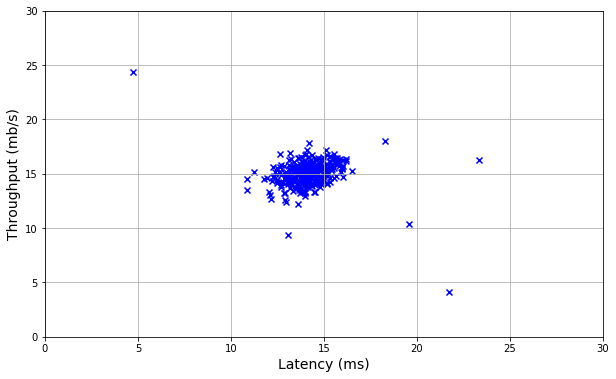

In [3]:
plt.figure()
plt.grid()
plt.scatter(X[:,0],X[:,1],marker='x',c='b')
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel('Latency (ms)',fontsize=14)
plt.ylabel('Throughput (mb/s)',fontsize=14)
plt.show()

## 1.2 Estimating Parameters for a Gaussian
- Estimate the Gaussian parameters for each feature:

$$
\begin{split}
\mu_i & = \frac{1}{m}\sum_{j=1}^m x_i^{(j)}\\
\sigma_i^2 & = \frac{1}{m}\sum_{j=1}^m \left(x_i^{(j)}-\mu_i\right)^2
\end{split}
$$

In [4]:
def estimateGaussian(X):
    '''
    Estimates Gaussian distribution parameters mu and variance for each feature 
    
    Parameters
    ------------
    X: m by n design matrix
    
    Returns
    ------------
    mu: n-dimensional vector with means of features
    sigma: n-dimensional vector with variances of features
    '''    
    # Both methods use the 1/m convention for averaging by default
    mu = np.mean(X,axis=0) # average along columns
    sigma2 = np.std(X,axis=0) # std along column
    
    return mu, sigma2

- Estimate $\mu$ and $\sigma^2$:

In [5]:
mu, sigma2 = estimateGaussian(X)

- We'll be using a multi-variate (MVT) Gaussian distribution for the fit. Implement it such that if a the variable `sigma2` passed in is a matrix it will be treated as the covariance matrix 

$$
\begin{split}
\Sigma & = \frac{1}{m}\sum_{i=1}^m\left(x^{(i)}-\mu\right)\left(x^{(i)}-\mu\right)^T\\
 & = \frac{1}{m}\left(X-\mu\right)^T\cdot\left(X-\mu\right)
\end{split}
$$

for design matrix $X$ or if its a vector treated as the $\sigma^2$ values of the variances in each dimension, i.e a diagonal covariance matrix

$$
\Sigma = \text{diag}(\sigma_1^2,\ldots,\sigma_n^2)
$$

, either of shape $n\times n$, where the mean is defined as:

$$
\mu = \frac{1}{m}\sum_{i=1}^m x^{(i)}
$$

- Note that the MVT distribution probability (scalar) is defined $\it{per}$ sample vector $x^{(i)}$ as:

$$
p_i\left(x^{(i)};\mu,\Sigma\right) = \frac{1}{(2\pi)^{(n/2)}\det{\Sigma}^{1/2}}\exp\left(\frac{-1}{2}\left(x^{(i)}-\mu\right)^T\cdot\Sigma^{-1}\cdot\left(x^{(i)}-\mu\right)\right).
$$

Since we have $m$ such samples we'll have a vector $p$ of length $m$. To vectorize this we need to use a Hadamard (entrywise) product as well alongside matrix multiplication. Each entry of the final p vector will have to be computed as a sum along the rows of the result of the previous (sentence) step. Each entry of this vector is then:


$$
p_i\left(X;\mu,\Sigma\right)=\frac{1}{(2\pi)^{(n/2)}\det{\Sigma}^{1/2}}\exp\left( -\frac{1}{2}\sum_{j}\left[\left(X-\mu\right) \circ \left[\Sigma^{-1} \cdot \left(X-mu\right)^T\right]^T\right]_{ij} \right)
$$

- Note that since, in the following, we are using a symmetric covariance matrix $\Sigma$ this problem will give us axes-aligned contours

In [6]:
def multivariateGaussian(X,mu,sigma2):
    '''
    Computes MVT Gaussian Distribution probabilities of samples in design matrix X
    
    Parameters
    ------------
    X: m by n design matrix
    mu: n-dimensional vector with means of features
    sigma2: n-dimensional vector with variances of features

    
    Returns
    ------------
    p: m-dimensional vector of MVT probability values of samples
    ''' 
    
    if (sigma2.ndim==1): # i.e if a vector
        sigma2 = np.diag(sigma2)
    
    n = mu.shape[0] # feature space dimension
    m = X.shape[0] # sample set size
    normalizing_factor = 1/((2*pi)**(n/2)*det(sigma2)**(0.5))
    
    exponential_arg = (X-mu)*((inv(sigma2)) @ (X-mu).T).T # will give matrix of shape m by n 
    if X.ndim != 1: # if there is more than one sample
        exponential_arg = np.sum(exponential_arg,axis=1) # sum along each row, now a vector of length m
    elif X.ndim == 1: # if there is only one sample
        exponential_arg = np.sum(exponential_arg,axis=0) # sum along the only row        
    density = np.exp(-0.5*exponential_arg)
    p = normalizing_factor * density # final probability vector
    
    return p

- Get the density of the MVT Distribution at each data point

In [7]:
p = multivariateGaussian(X,mu,sigma2)

- Now we need to show its contours so we need to compute the MTV on points on a grid:

In [8]:
# Create a mesh to plot in
h = .05  # Step size in the mesh
x1_min, x1_max = 0, 30
x2_min, x2_max = 0, 30
x1_range, x2_range = np.meshgrid(np.arange(x1_min, x1_max, h),
                     np.arange(x2_min, x2_max, h))
grid_prob = np.empty((np.shape(x1_range)[0],np.shape(x1_range)[1])) # allocate space for the MTV over grid

# Since the function multivariateGaussian() was not written to expect and "x" and a "y" but rather a matrix X
# I can't call it directly with the mesh grid values. Rather I will loop through the values and evaluate it at each pair/point
for idx_x1,ii_x1 in enumerate(x1_range[0,:]):
    for idx_x2,ii_x2 in enumerate(x2_range[:,0]):
        grid_prob[idx_x2][idx_x1] = multivariateGaussian(np.array([ii_x1,ii_x2]),mu,sigma2)

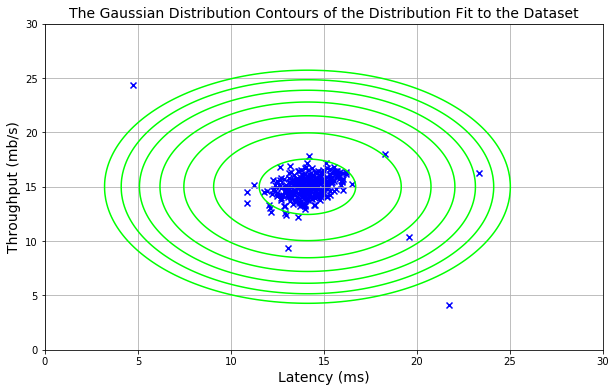

In [9]:
# Plot
plt.figure()
plt.grid(True)
cont_levels = [10**exp for exp in range(-20,0,3)]
CS = plt.contour(x1_range,x2_range,grid_prob,levels=cont_levels,colors='lime') # only plot where prediction = 0.5
plt.scatter(X[:,0],X[:,1],marker='x',c='b')
plt.xlim(0,30)
plt.ylim(0,30)
plt.xlabel('Latency (ms)',fontsize=14)
plt.ylabel('Throughput (mb/s)',fontsize=14)
plt.title('The Gaussian Distribution Contours of the Distribution Fit to the Dataset',fontsize=14)
plt.show()

- We can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities

## 1.3 Selecting the Threshold $\epsilon$
- Now we investigate which examples have a very high and very low probability given this distribution. The low probability samples are most likely anomalies in out dataset
- One way to determine anomalies is to select a threshold $\epsilon$ based on a cv set. Here we will implement an algorithm to select the threshold using the $F_1$ score on a cv set
- The cv set is $\{(x_{cv}^{(1)},y_{cv}^{(1)}),\ldots,(x_{cv}^{(m_{cv})},y_{cv}^{(m_{cv})})\}$ where $y=1$ corresponds to anomalous samples and $y=0$ to normal samples. Then, for each cv sample we will ompute $p\left(x_{cv}^{(i)}\right)$. The vector of all these probabilities will be used for labeling with the MTV distribution

In [10]:
Xval,yval = data1['Xval'],data1['yval'].flatten() # Load cv set

In [11]:
pval = multivariateGaussian(Xval,mu,sigma2) # Compute probabilities based on training model

- We'll step through different values of $\epsilon$ from the minimum to the maximum of the $p_{val}$ vector
- At each value of $\epsilon$ we assign labels to the cv set samples with the criteria:

$$
y_{cv}^{(i)}=\left\{
            \begin{array}{ll}
              1 & \text{if } p(x_{cv}^{(i)})<\epsilon\\
              0 & \text{if } p(x_{cv}^{(i)})\geq\epsilon
            \end{array}
          \right.
$$

- The performance of a particular choice of $\epsilon$ is then gauged with the score:

$$
F_1 = 2\frac{PR}{P+R}
$$

where the precision $P$ and recall $R$ are:

$$
\begin{split}
P & = \frac{\text{True Positives}}{\text{True Positives + False Positives}}\\
R & = \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
\end{split}
$$

In [12]:
def selectThreshold(yval,pval):
    '''
    Computes the best threshold value for anomaly detection using the F1 score
    given sample labels and probability values
    
    Parameters
    ------------
    yval: m-dimensional vector of sample labels 
    p: m-dimensional vector of MVT probability values of samples
    
    Returns
    ------------
    bestEpsilon : threshold value for anomaly detection which gave best F1 score
    bestF1 : F1 score which for optimal threshold value in anomaly detection
    ''' 
    bestEpsilon = 0
    bestF1 = 0
    min_pval = np.min(pval)
    max_pval = np.max(pval)
    stepsize = (max_pval-min_pval)/1000
    epsilon_vals = np.arange(min_pval,max_pval+stepsize,stepsize) # threshold values to try
    
    for ii_epsilon in epsilon_vals:
        ii_label = (pval<ii_epsilon).astype(int) # assigned labels using this threshold
        ii_true_pos = sum(ii_label[np.argwhere(yval==1).flatten()]==1) # true positives
        ii_false_pos = sum(ii_label[np.argwhere(yval==0).flatten()]==1) # false positives
        ii_false_neg = sum(ii_label[np.argwhere(yval==1).flatten()]==0) # false negatives
        ii_precision = ii_true_pos/(ii_true_pos+ii_false_pos) # precision
        ii_recall = ii_true_pos/(ii_true_pos+ii_false_neg) # recall
        ii_f1 = 2*ii_precision*ii_recall/(ii_precision+ii_recall) # f1 score
        if ii_f1 > bestF1: # is F1 score is better, save it and the theshold value
            bestF1 = ii_f1
            bestEpsilon = ii_epsilon
    
    return bestEpsilon,bestF1

- Get best $\epsilon$ and $F_1$:

In [13]:
epsilon,F1 = selectThreshold(yval,pval)

print('Best epsilon found using cross-validation set: {}'.format(epsilon))
print('Best F1 on cross-validation set: {}'.format(F1))

/home/les67/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in long_scalars


Best epsilon found using cross-validation set: 0.00011961829186145725
Best F1 on cross-validation set: 0.8750000000000001


- Find the outliers in the training set (not cv set) and plot them:

In [14]:
outliers = (p < epsilon)

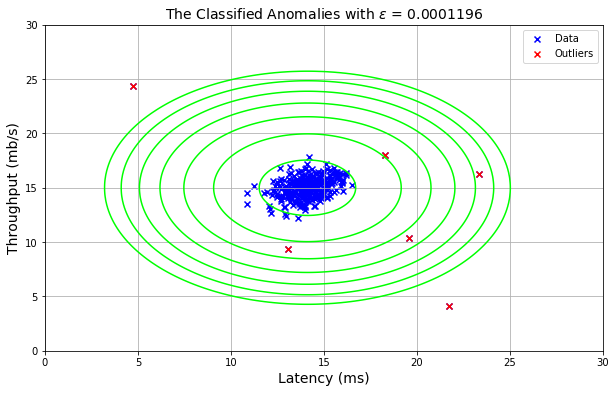

In [15]:
# Plot
plt.figure()
plt.grid(True)
CS = plt.contour(x1_range,x2_range,grid_prob,levels=cont_levels,colors='lime') # only plot where prediction = 0.5
plt.scatter(X[:,0],X[:,1],marker='x',c='b',label='Data')
plt.scatter(X[outliers,0],X[outliers,1],marker='x',c='r',label='Outliers')
plt.xlim(0,30)
plt.ylim(0,30)
plt.legend(loc='upper right')
plt.xlabel('Latency (ms)',fontsize=14)
plt.ylabel('Throughput (mb/s)',fontsize=14)
plt.title(r'The Classified Anomalies with $\epsilon$ = {:0.7f}'.format(epsilon),fontsize=14)
plt.show()

## 1.4 High-dimensioanl Dataset
- Now we'll run the above anomaly detection algorithm on a more realistic and much harder dataset consisting of 11 total features of the computer servers

In [16]:
data2 = loadmat('ex8data2.mat') # load data
X,Xval,yval = data2['X'],data2['Xval'],data2['yval'].flatten()

- Just for curiosity let's use the true covariance matrix and not the diagonal (symetric) approximation we used above. Let's write a method to compute this:

In [17]:
def computeCovariance(X,mu):
    '''
    Computes covariance matrix of design matrix given average feature values mu
    
    Parameters
    ------------
    X: m by n array, design matrix
    mu: n-dimensional vector, average feature values    

    Returns
    ------------
    covariance_matrix : n by n array, covariance matrix of X and mu
    ''' 
    m = X.shape[0]
    covariance_matrix = 1/m*(X-mu).T @ (X-mu)
    return covariance_matrix

In [18]:
mu,_ = estimateGaussian(X) # fit the model to training set, ignore this sigma2
sigma2 = computeCovariance(X,mu) # get covariance matrix
p = multivariateGaussian(X,mu,sigma2) # compute probabilities of training set with model
pval = multivariateGaussian(Xval,mu,sigma2) # compute probs of cv set with model
epsilon,F1 = selectThreshold(yval,pval) # select optimal threshold

/home/les67/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in long_scalars


In [19]:
print('Best epsilon found using cross-validation set: {}'.format(epsilon))
print('Best F1 on cross-validation set: {}'.format(F1))
print('# of outliers found: {}'.format(sum((p < epsilon))))

Best epsilon found using cross-validation set: 1.753848871245879e-18
Best F1 on cross-validation set: 0.5517241379310345
# of outliers found: 122


# 2. Recommender Systems
- Here we'll implement collaborative filtering and apply it to a dataset of movie ratings
- This dataset consists of ratings on a scale of 1 to 5, has $n_u=943$ users and $n_m=1682$ movies

## 2.1 Movie Ratings Dataset
- We'll be dealing with the matrices:
    - $X$ of shape $n_m\times n$, the design matrix, where the $i$-th row corresponds to the feature vector $x^{(i)}$ for the $i$-th movie. Recall that a feature is a percentage value for a genre content within the movie such as romance, action, comedy, etc
    - $\Theta$ of shape $n_u\times n$ where the $j$-th row corresponds to one parameter vector $\theta^{(j)}$ for the $j$-th user
    - Here we will use $n=100$ so $x^{(i)}\in \mathbb{R}^{100}$ and $\theta^{(i)}\in \mathbb{R}^{100}$
- First load the data where:
    - matrix $Y$ (ratings matrix) stores the ratings $y^{(i,j)}$ from 1 to 5 of shape $n_m\times n$
    - matrix $R$ (indicator matrix)is binary-valued, i.e $R(i,j)=1$ if user $j$ gave a rating to movie $i$ and 0 otherwise; of shape $n_m\times n$

In [45]:
data3 = loadmat('ex8_movies.mat')
R = data3['R'] # of shape 1682 by 943
Y = data3['Y'] # of shape 1682 by 943

- Compute the average of ratings for Toy Story whose ratings are on the first row of the matrix $Y$. However, we can't count the movies that haven't been rated (which hold the value 0) in the mean, so we count the non-zeros entries and compute the mean manually instead of using np.mean: 

In [47]:
# Compute some statistics 
ts_movie_rating = np.true_divide(Y.sum(axis=1),(Y!=0).sum(axis=1))[0] # axis 1 is along each row
                                                                      # 0th entry for Toy Story
print('Average rating for movie 1 (Toy Story): {:0.2f}'.format(ts_movie_rating))

Average rating for movie 1 (Toy Story): 3.88


- We can "visualize" the ratings matrix by plotting it with imshow:

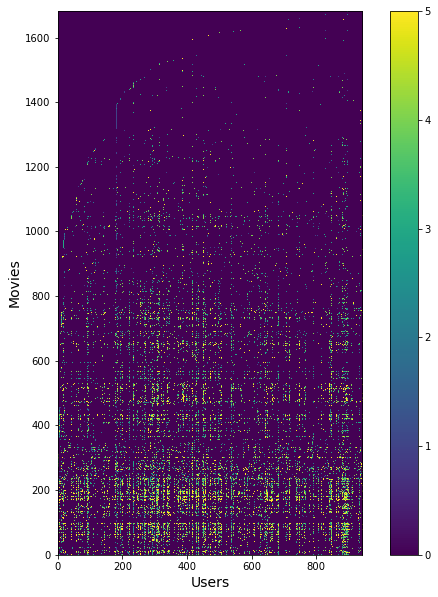

In [57]:
plt.figure(figsize=(10,10))
plt.imshow(Y)
plt.gca().invert_yaxis()
plt.colorbar()
plt.ylabel('Movies',fontsize=14)
plt.xlabel('Users',fontsize=14)
plt.show()

## 2.2 Collaborative Filtering Algorithm
- Now implement the collaborative filtering algorithm 
- First load pre-trained weights ($X$, $\Theta$, $n_u$, $n_m$ and $n$)

In [63]:
data4 = loadmat('ex8_movieParams.mat')
Theta = data4['Theta'] # 943 by 10
X = data4['X'] # 1682 by 10
num_users = data4['num_users'][0][0] # = 943
num_movies = data4['num_movies'][0][0] # = 1682
num_features = data4['num_features'][0][0] # = 10

- Reduce the data set size to that methods run faster:

In [72]:
num_users = 4
num_movies = 5
num_features = 3
X = X[:num_movies,:num_features] # 5 by 3
Theta = Theta[:num_users,:num_features] # 4 by 3
Y = Y[:num_movies,:num_users] # 5 by 4
R = R[:num_movies,:num_users] # 5 by 4

- Implement the cost function:

$$
J(x^{(1)},\ldots,x^{(n_m)},\theta^{1},\ldots,\theta^{(n_u)})=\frac{1}{2}\sum_{(i,j):r(i,j)=1}\left(\left(\theta^{(j)}\right)^Tx^{(i)}-y^{(i,j)}\right)^2 + \frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^n \left(\theta_k^{(j)}\right)^2 + \frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^n \left(x_k^{(i)}\right)^2 
$$

If we define the vector $\mathbf{e}$ as a vector with 1's for all entries and of appropriate size (into whatever matrix its multiplying into and whose effect is to sum all the entries in the matrices they sandwhich) then we can write all this in vectorized form as:

$$
J = \left[\mathbf{e}^T\cdot\left(X\Theta^T-Y\right)\circ\left(X\Theta^T-Y\right)\cdot\mathbf{e}\right]+\frac{\lambda}{2}\left[\mathbf{e}^T\cdot\Theta\circ\Theta\cdot\mathbf{e}\right]+\frac{\lambda}{2}\left[\mathbf{e}^T\cdot X\circ X\cdot\mathbf{e}\right]
$$

- Note that the argument of this function is a long vector containing the $x^{(i)}$s and $\theta^{(j)}$s. To use the minimizers we also have to provide a vector (not matrix or matrices of values). Thus we have to reshape the $X$ and $\Theta$ arrays into a flattened vector

In [73]:
params = np.r_[X.flatten(),Theta.flatten()] # parameter vector for cost function and grad

In [111]:
Y.shape

(5, 4)

In [112]:
def cofiCostFunc(params,Y,R,num_users,num_movies,num_features,reg_param=0):
    '''
    Computes cost function for collaborative filtering
    
    Parameters
    ------------
    params: 1 by (num_movies+num_users)*num_features vector containing xs and thetas
    Y: num_movies by num_users matrix containing movie ratings
    R: num_movies by num_users matrix of 1s and 0s denoting is a movie was rated or not
    reg_param: scalar (default 0), regularization parameter lambda

    Returns
    ------------
    costJ: scalar, cost function value for given parameters
    '''    
    # Get X and Theta back
    X = np.reshape(params[:num_movies*num_features],(num_movies,num_features))
    Theta = np.reshape(params[num_movies*num_features:],(num_users,num_features))
    
    main_arg = (((X@Theta.T) - Y)**2).flatten() # for first argument of cost function
    rated_cut = R.astype(bool).flatten() # from 1s and 0s to True/False 
    costJ = 0.5*np.sum(main_arg[rated_cut]) # only sum those that were rated
    
    # Regularization terms
    if reg_param!=0:
        costJ += reg_param/2*np.sum(Theta**2)
        costJ += reg_param/2*np.sum(X**2)
    
    return costJ

In [113]:
J = cofiCostFunc(params,Y,R,num_users,num_movies,num_features) # compute cost function with given parameters

print('Cost at loaded parameters: {:0.2f}'.format(J)) # should be 22.22

Cost at loaded parameters: 22.22


## 2.3 Learning Movie Recommendations